## Imports

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, lognorm, gamma
from tabulate import tabulate
from random import random, gammavariate
from math import sqrt, exp

## Funciones auxiliares

In [83]:
def media_muestral(datos):
    n = len(datos)
    media = sum(datos) / n
    return media

def var_muestral(datos):
    n = len(datos)
    media = media_muestral(datos)
    varianza = sum(list(map(lambda x: (x - media)**2, datos)))
    varianza = varianza / (n - 1)
    return varianza

## Funciones generales (Test para datos continuos)
def generar_muestra(generador, n):
    """
    Genera una muestra de tamaño n de una variable aleatoria
    Args:
        generador:    Generador de la variable aleatoria
        n        :    Tamaño de la muestra
    """
    datos = []
    for _ in range(n):
        datos.append(generador())
    return datos

def calcular_D(muestra, acumulada_h):
    """
    Calcula el estadistico dado en el test de Kolmogorov-Smirnov
    Args:
        muestra    :    Muestra original de datos
        acumulada_h:    Acumulada de la distribucion de la hipotesis nula
    """
    n = len(muestra)
    m_copy = list.copy(muestra)
    m_copy.sort()
    m_copy = np.array(m_copy)

    # Vectores_auxiliares
    F = np.array(list(map(acumulada_h, m_copy)))
    j = np.array(list(range(1, n+1))) / n
    j_1 = j - 1/n

    m1 = max(j - F)
    m2 = max(F - j_1)
    D = max(m1, m2)
    return D


def acumulada_uniforme(x):
    """
    Acumulada de la distribucion uniforme (U(0, 1))
    """
    if x < 0:
        return 0
    elif x < 1:
        return x
    else:
        return 1


def estimar_p_valor_k(d, Nsim, n):
    """
    Estima el p-valor por medio de simulacion P(D >= d)
    args:
        d   :    Valor del estadistico en la muestra original
        Nsim:    Cantidad de simulaciones a realizar
        n   :    Tamaño de la muestra original
    """
    p_valor = 0
    for _ in range(Nsim):
        muestra_sim = generar_muestra(random, n)    # Muestra de uniformes
        muestra_sim.sort()
        d_sim = calcular_D(muestra_sim, acumulada_uniforme)
        if d_sim >= d:
            p_valor += 1
    return p_valor / Nsim

+--------------+--------------+-------------------+-------------------+-------------------+
| Valor máximo | Valor mínimo |       Media       |     Varianza      |     Asimetría     |
+--------------+--------------+-------------------+-------------------+-------------------+
| 13.34285563  |  0.11112802  | 3.017981258766669 | 3.209765018050256 | 1.398714871716441 |
+--------------+--------------+-------------------+-------------------+-------------------+


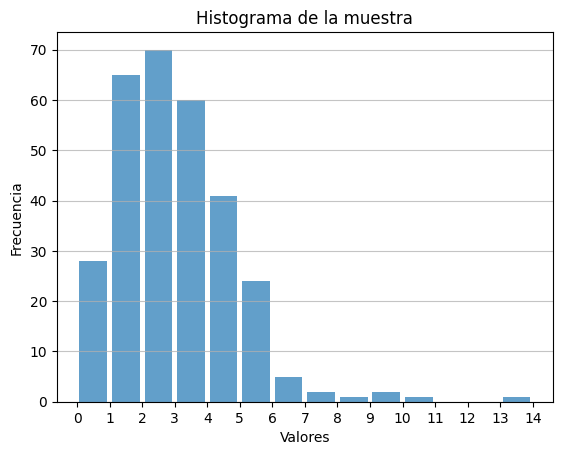

Cuantiles (25%, 50%, 75%): [1.72947114 2.83624832 4.03033519]


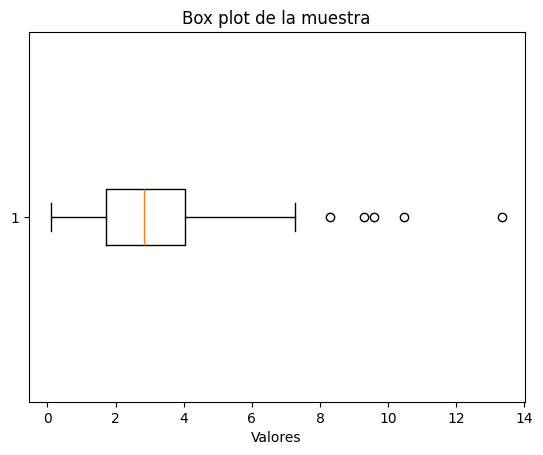

In [84]:
# Ejercicio 1
# a) 
# Cargamos los datos
data = np.loadtxt('sample24.dat')

# Calculamos las estimaciones muestrales
val_max = np.max(data)
val_min = np.min(data)
media = media_muestral(data)
varianza = var_muestral(data)
asimetria = skew(data)

data_print = [[val_max, val_min, media, varianza, asimetria]]
headers = ["Valor máximo", "Valor mínimo", "Media", "Varianza", "Asimetría"]
print(tabulate(data_print, headers=headers, tablefmt="pretty"))

# b) 
# Confeccionamos un histograma
intervalos = range(int(val_min-1), int(val_max+2))
plt.hist(data, bins=intervalos, alpha=0.7, rwidth=0.85)
plt.title('Histograma de la muestra')
plt.xticks(intervalos)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

# c) 
# Hacemos el estudio de cuantiles y confeccionamos la box plot
cuantiles = np.percentile(data, [25, 50, 75])
print(f'Cuantiles (25%, 50%, 75%): {cuantiles}')

plt.boxplot(data, vert=False)
plt.title('Box plot de la muestra')
plt.xlabel('Valores')
plt.show()


In [85]:
## Ejercicio 2

# Propuestas de distribuciones

# 1. Distribución Log-Normal
# Estimamos los parámetros de la distribución log-normal por maxima verosimilitud
ln_x = np.log(list(data))
mu = np.mean(ln_x)
sigma2 = np.mean((ln_x - mu) ** 2)
sigma = np.sqrt(sigma2)

# 2. Distribución Gamma
# Estimamos los parámetros de la distribución gamma por maxima verosimilitud
# La media de la distribución gamma es E[X] = k * theta
# La varianza de la distribución gamma es Var[X] = k * theta^2
# Dados los valores de la media y la varianza, podemos despejar k y theta
# k = media^2 / varianza
# theta = varianza / media
k = media**2 / varianza
theta = varianza / media


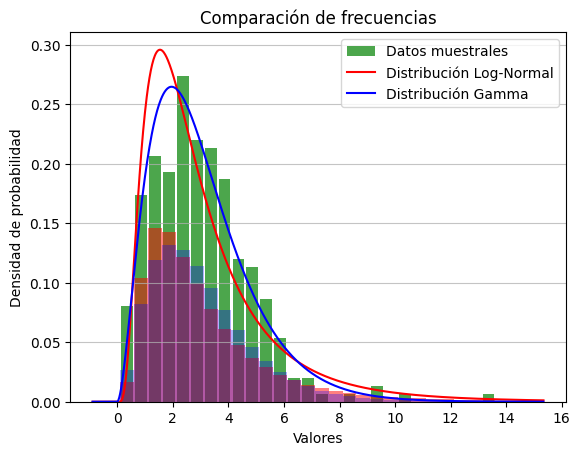

In [86]:
## Ejercicio 3
# a)
intervalos = np.arange(val_min-1, val_max+2, 0.5)
hist, bins = np.histogram(data, bins=intervalos, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]

# Calculamos las densidades de las distribuciones propuestas
x = np.linspace(val_min-1, val_max+2, 1000)
lognorm_density = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
gamma_density = gamma.pdf(x, a=k, scale=theta)

# Graficamos el histograma
plt.hist(data, bins=intervalos, density=True, color='g', alpha=0.7, rwidth=0.85, label='Datos muestrales')

# Superponemos las funciones de densidad
plt.plot(x, lognorm_density, 'r-', label='Distribución Log-Normal')
plt.plot(x, gamma_density, 'b-', label='Distribución Gamma')

# Superponemos las barras ajustadas al histograma
for center, h in zip(bin_centers, hist):
    plt.bar(center, lognorm.pdf(center, s=sigma, scale=np.exp(mu)) * width, width=width, alpha=0.5, color='r')
    plt.bar(center, gamma.pdf(center, a=k, scale=theta) * width, width=width, alpha=0.3, color='b')

plt.title('Comparación de frecuencias')
plt.xlabel('Valores')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [87]:
# c)
# Test de Kolmogorov-Smirnov
def acumulada_lognorm(x):
    if x < 0:
        return 0
    else:
        return (1/(x * sqrt(2 * np.pi * sigma**2))) * exp(-(((np.log(x) - mu)**2) / (2*(sigma**2))))

data = list(data)

# Calculamos el estadistico d para cada distribucion
d_lognorm = calcular_D(data, lambda x: lognorm.cdf(x, s=sigma, scale=np.exp(mu)))
d_gamma = calcular_D(data, lambda x: gamma.cdf(x, a=k, scale=theta))
n = len(data)

# Estimamos los p-valores
Nsim = 10**2
p_valor_lognorm = estimar_p_valor_k(d_lognorm, Nsim, n)
p_valor_gamma = estimar_p_valor_k(d_gamma, Nsim, n)


# Estimamos el p-valor con una simulacion mas certera (calculando estadisticos de muestras con distribucion H0)
p_valor_sim_lognorm = 0
p_valor_sim_gamma = 0
scale = np.exp(mu)
for _ in range(Nsim):
    # Generamos la muestra a partir de las distribuciones "originales"
    muestra_sim_lognorm = list(lognorm.rvs(s=sigma, scale=scale, size=n))
    muestra_sim_gamma = list(gamma.rvs(a=k, scale=theta, size=n))

    # Reestimamos los parametros desconocidos
    ln_x_sim = np.log(muestra_sim_lognorm)
    mu_sim = np.mean(ln_x_sim)
    sigma2_sim = np.mean((ln_x_sim - mu_sim) ** 2)
    sigma_sim = np.sqrt(sigma2_sim)

    # mu_sim = np.log(media_sim**2 / np.sqrt(varianza_sim + media_sim**2))
    # sigma_sim = np.sqrt(np.log(varianza_sim / media_sim**2 + 1))

    # media_sim = media_muestral(muestra_sim_gamma)
    # varianza_sim = var_muestral(muestra_sim_gamma)


    media_sim = media_muestral(muestra_sim_gamma)
    varianza_sim = var_muestral(muestra_sim_gamma)

    k_sim = media_sim**2 / varianza_sim
    theta_sim = varianza_sim / media_sim

    # Calculamos el estadistico de la simulacion usando los parametros estimados
    d_sim_lognorm = calcular_D(muestra_sim_lognorm, lambda x: lognorm.cdf(x, s=sigma_sim, scale=np.exp(mu_sim)))
    d_sim_gamma = calcular_D(muestra_sim_gamma, lambda x: gamma.cdf(x, a=k_sim, scale=theta_sim))

    if d_sim_lognorm > d_lognorm:
        p_valor_sim_lognorm += 1

    if d_sim_gamma > d_gamma:
        p_valor_sim_gamma += 1

p_valor_sim_lognorm = p_valor_sim_lognorm / Nsim
p_valor_sim_gamma = p_valor_sim_gamma / Nsim

data = [[mu, sigma, p_valor_lognorm, p_valor_sim_lognorm]]
headers = ["μ estiamdo", "σ estimado", "P-valor (Uniformes)", "P-valor Simulada"]

print ("Distribución Log-Normal")
print(tabulate(data, headers=headers, tablefmt="pretty"))

data_print = [[k, theta, p_valor_gamma, p_valor_sim_gamma]]
headers = ["k estiamdo", "θ estimado", "P-valor (Uniformes)", "P-valor Simulada"]

print("\n")
print ("Distribución Gamma")
print(tabulate(data_print, headers=headers, tablefmt="pretty"))


Distribución Log-Normal
+-------------------+--------------------+---------------------+------------------+
|    μ estiamdo     |     σ estimado     | P-valor (Uniformes) | P-valor Simulada |
+-------------------+--------------------+---------------------+------------------+
| 0.907760881529684 | 0.6912636929475174 |        0.01         |       0.02       |
+-------------------+--------------------+---------------------+------------------+


Distribución Gamma
+--------------------+--------------------+---------------------+------------------+
|     k estiamdo     |     θ estimado     | P-valor (Uniformes) | P-valor Simulada |
+--------------------+--------------------+---------------------+------------------+
| 2.8376565969927454 | 1.0635470345372395 |        0.57         |       0.18       |
+--------------------+--------------------+---------------------+------------------+
